In [2]:
import scvi
import os
import tempfile
import scanpy as sc
import scarches as sca
import seaborn as sns
import torch
import pandas as pd
from rich import print
import numpy as np
import matplotlib.pyplot as plt
import skmisc

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [3]:
scvi.settings.seed = 42
torch.set_float32_matmul_precision('high')

[rank: 0] Seed set to 42


In [4]:
adata = sc.read("/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_1_scvi/sce_all_pre.h5ad")
adata

AnnData object with n_obs × n_vars = 18043 × 19463
    obs: 'bc_wells', 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'doublet_score', 'predicted_doublets', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'total', 'low_lib_size', 'low_n_features', 'high_subsets_mito_percent', 'discard', 'discard_mito', 'discard_feature', 'discard_final', 'sizeFactor', 'leiden_individual', 'leiden'
    var: 'gene_id', 'gene_name', 'genome', 'gene_version', 'gene_source', 'gene_biotype'
    uns: 'X_name'
    obsm: 'X_scVI', 'X_scVI_MDE'
    layers: 'logcounts'

In [5]:
adata_full = adata.copy()

In [6]:
sc.pp.highly_variable_genes(
    adata = adata, 
    flavor = "seurat_v3",
    n_top_genes = 5000, 
    subset = True
)

In [7]:
# integration with scVI
scvi.model.SCVI.setup_anndata(
    adata = adata, 
    batch_key = "sample"
)
# create model
scvi_model = scvi.model.SCVI(
    adata = adata,
    n_hidden = 128,
    n_latent = 50,
    dispersion = "gene"
)
# train model
# scvi.settings.dl_num_workers = 15
scvi_model.train(
    max_epochs = 1000, 
    early_stopping = True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 471/1000:  47%|████▋     | 471/1000 [07:34<08:30,  1.04it/s, v_num=1, train_loss_step=2.34e+3, train_loss_epoch=2.38e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 2472.894. Signaling Trainer to stop.


<Axes: xlabel='epoch'>

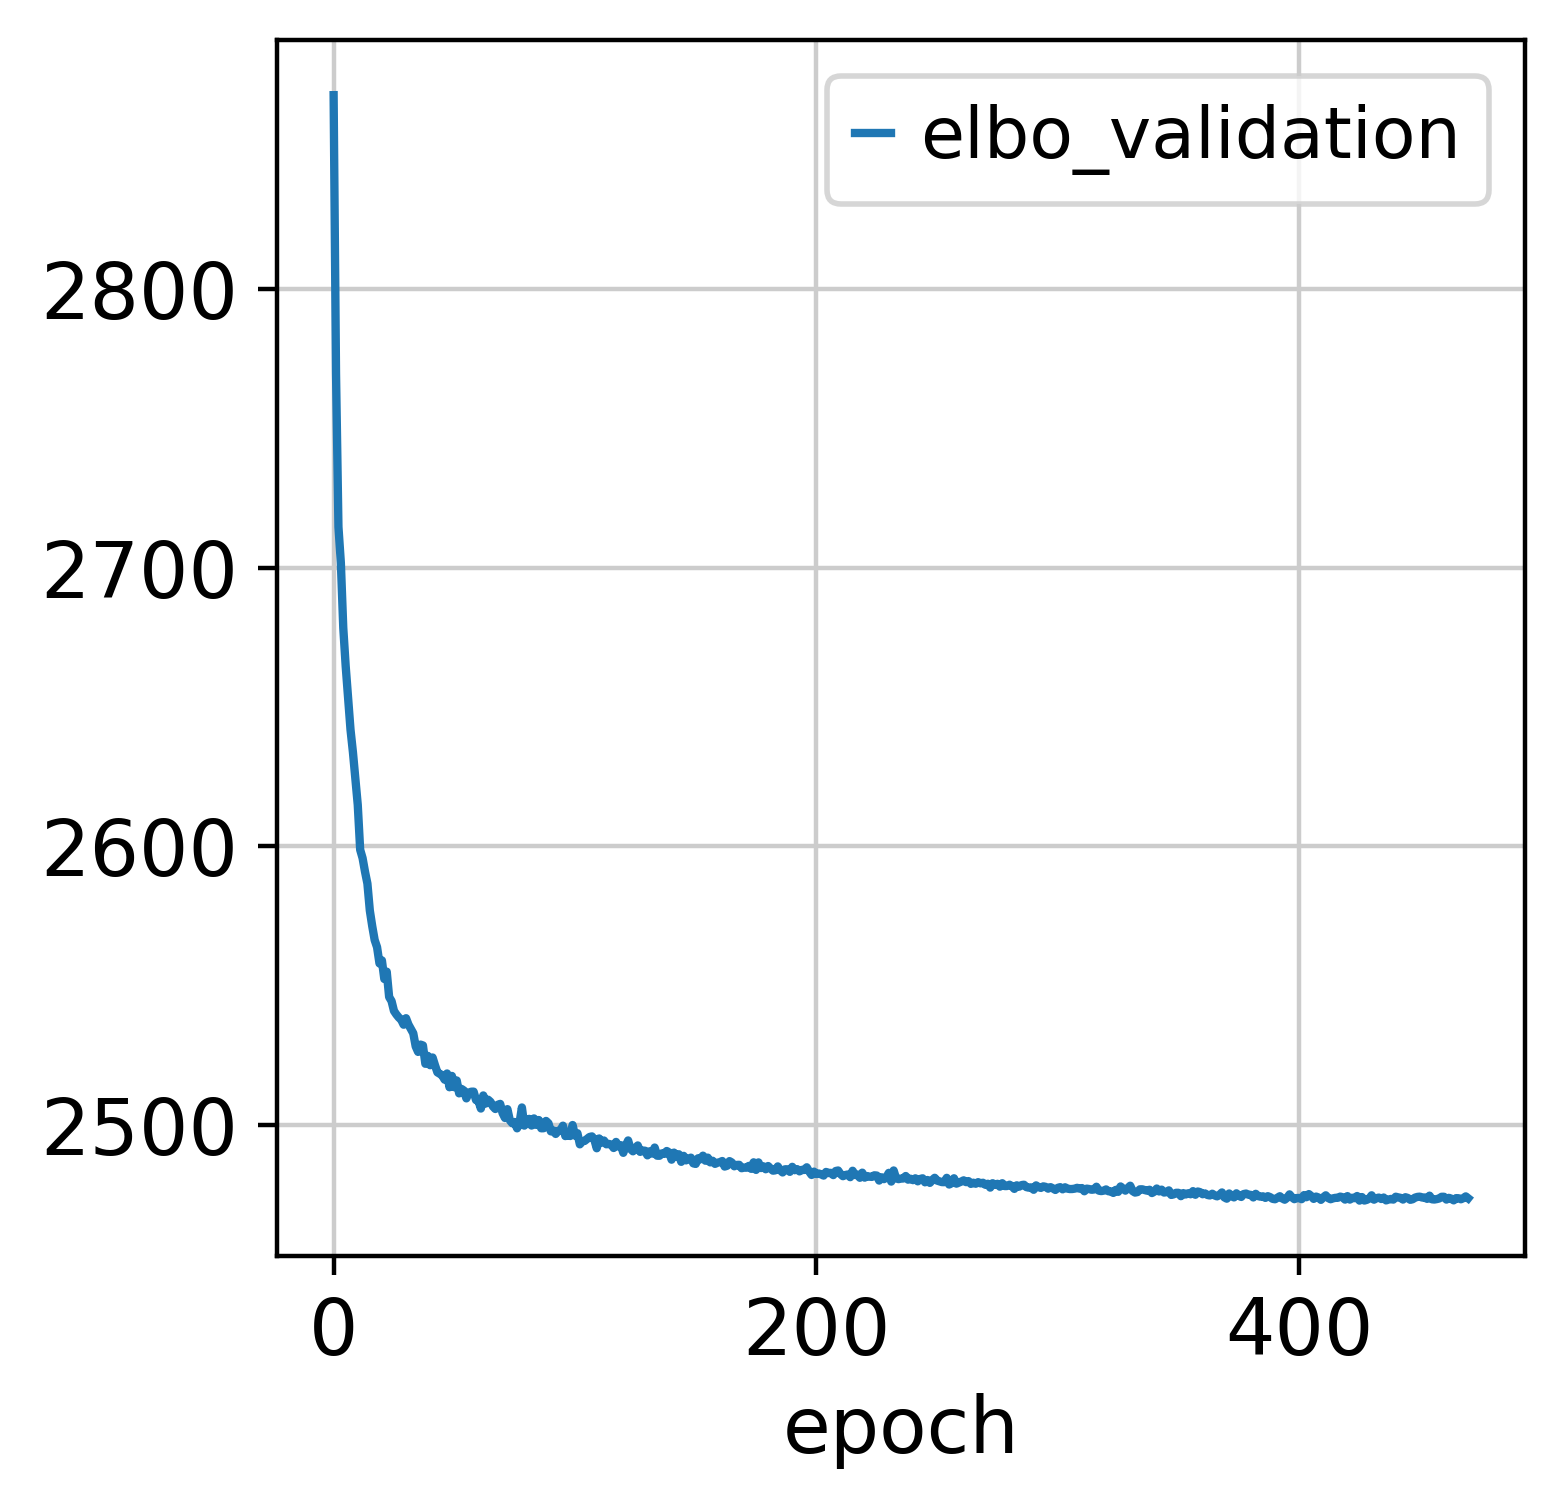

In [8]:
scvi_model.history["elbo_validation"].plot()

In [9]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation()

In [10]:
sc.pp.neighbors(
    adata = adata, 
    use_rep = SCVI_LATENT_KEY, 
    n_neighbors = 15,
    n_pcs = 50
)
sc.tl.umap(
    adata = adata, 
    min_dist = 0.005
)
sc.tl.leiden(
    adata,
    flavor = "igraph",
    # resolution = 1,
    # n_iterations = 10
)

In [11]:
SCVI_MDE_KEY = "X_scVI_MDE"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


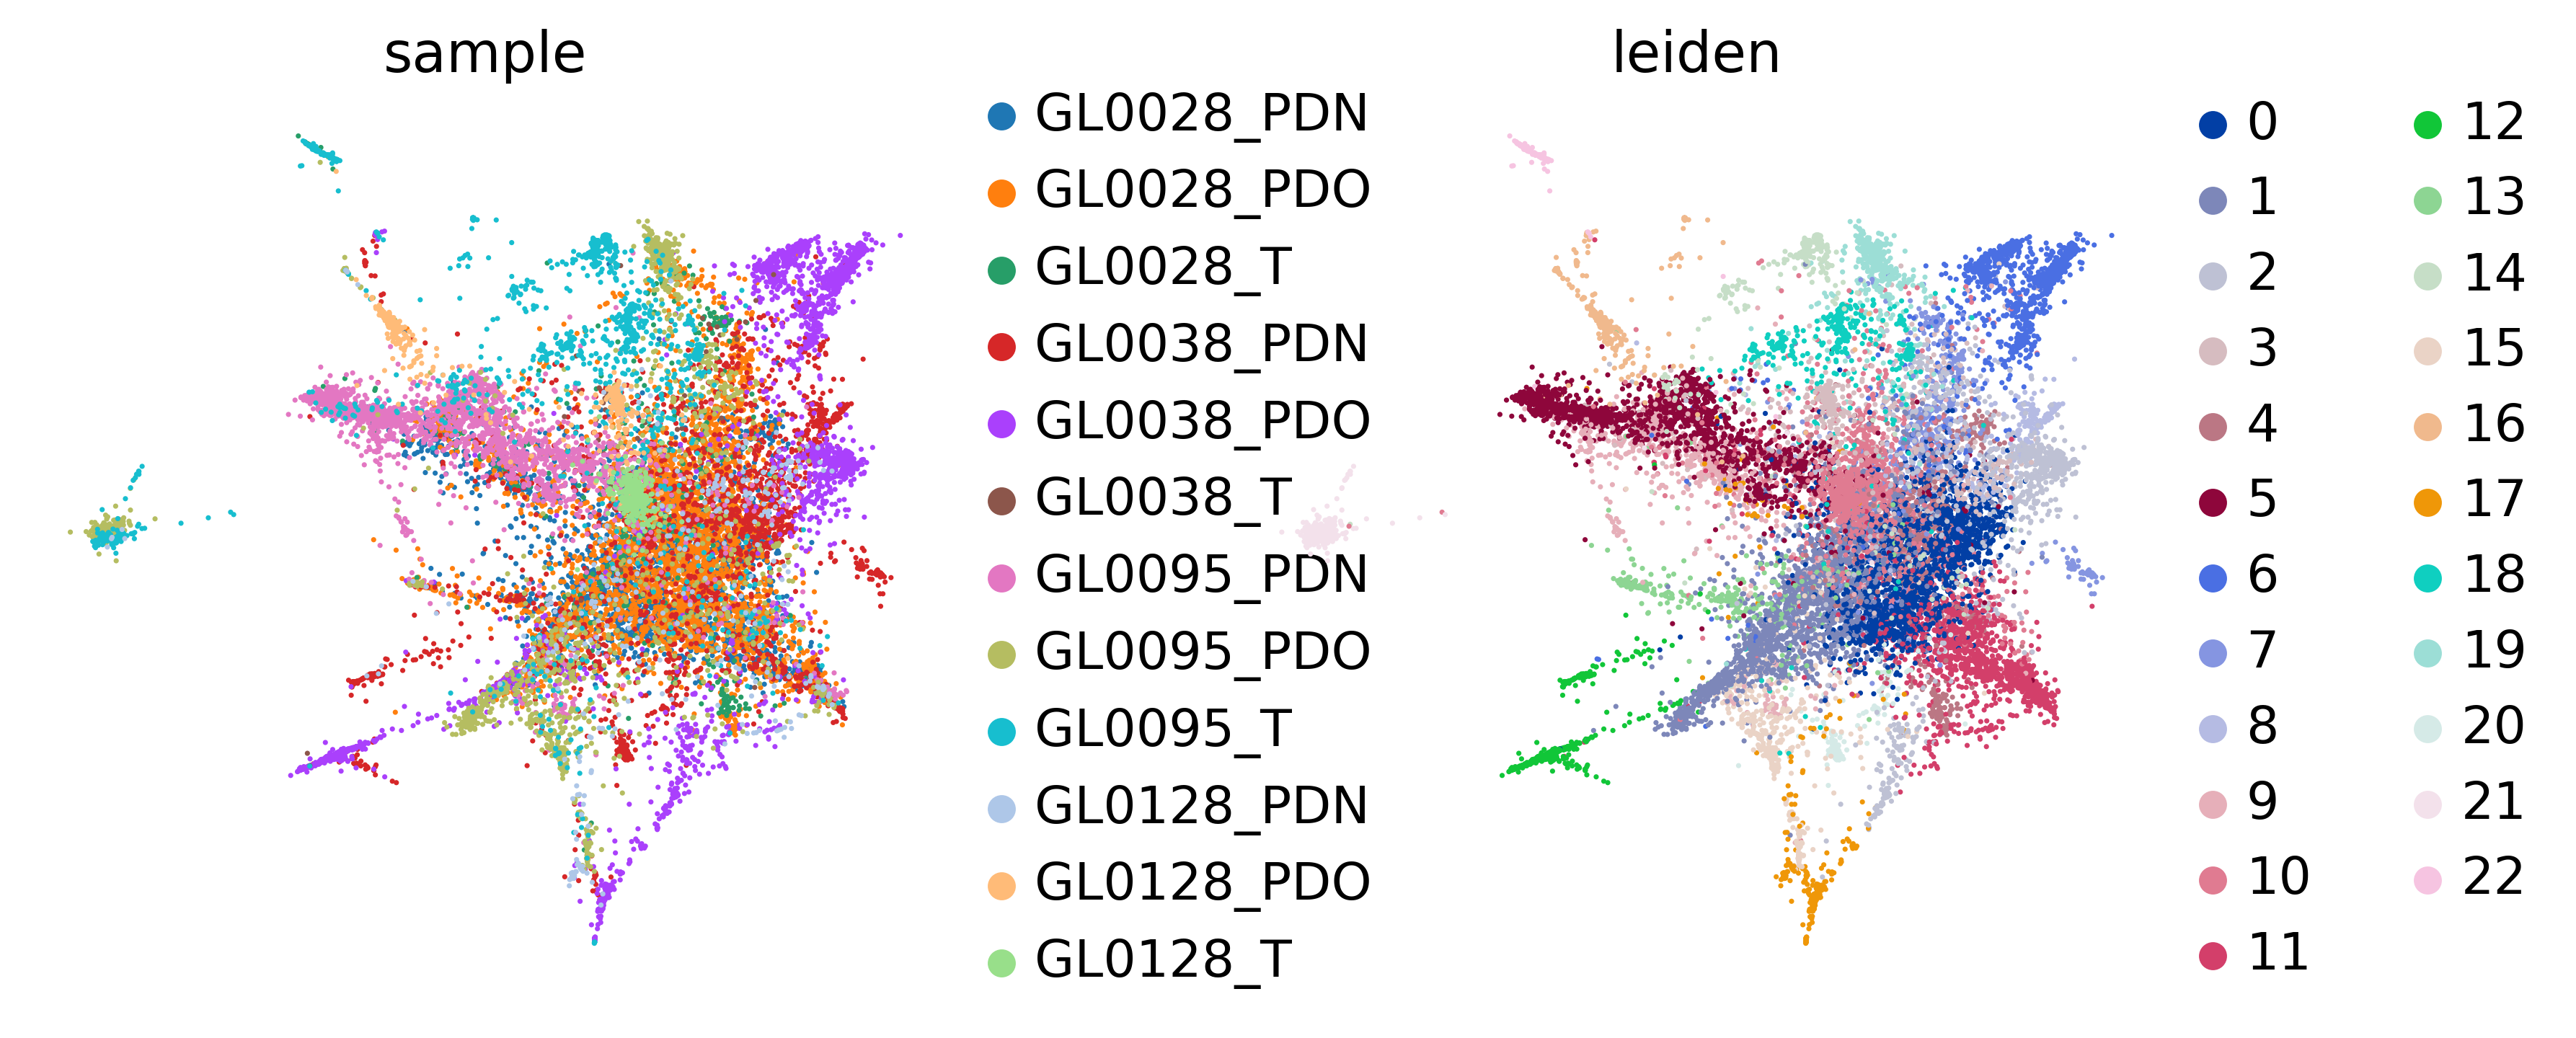

In [12]:
sc.pl.embedding(
    adata = adata,
    basis = SCVI_MDE_KEY,
    color = ["sample", "leiden"],
    # legend_loc = "on data",
    frameon = False,
    ncols = 2,
)

In [13]:
sc.pl.umap(
    adata = adata,
    color = ["sample", "leiden"],
    # legend_loc = "on data",
    frameon = False,
    ncols = 2,
)

In [ ]:
sc.pl.umap(
    adata = adata,
    # basis = SCVI_MDE_KEY,
    color = ["ENSG00000081237", "leiden"],
    # legend_loc = "on data",
    frameon = False,
    ncols = 2,
)

In [15]:
change_per_cluster = scvi_model.differential_expression(
    adata = adata, 
    groupby = "leiden", 
    batch_correction = True,
    filter_outlier_cells = False
)

DE...: 100%|██████████| 23/23 [03:53<00:00, 10.14s/it]


In [16]:
change_per_cluster.to_csv(path_or_buf = "/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_1_scvi/sce_all_cluster.csv")

In [17]:
leiden = (
    adata.obs["leiden"]
    .value_counts()
    # .loc[lambda x: (x >= 500) & (x.index != "nan")]
    .loc[lambda x: x.index != "nan"]
    .to_frame("n_cells")
)
leiden.loc[:, "associated_test"] = leiden.index.astype(str) + " vs Rest"

marker_genes = (
    change_per_cluster.reset_index()
    .loc[lambda x: x.comparison.isin(leiden.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("bayes_factor", ascending=False).iloc[:5]
    )  # Select top 5 DE genes per comparison
    .reset_index(drop=True)["index"]
    .unique()
)

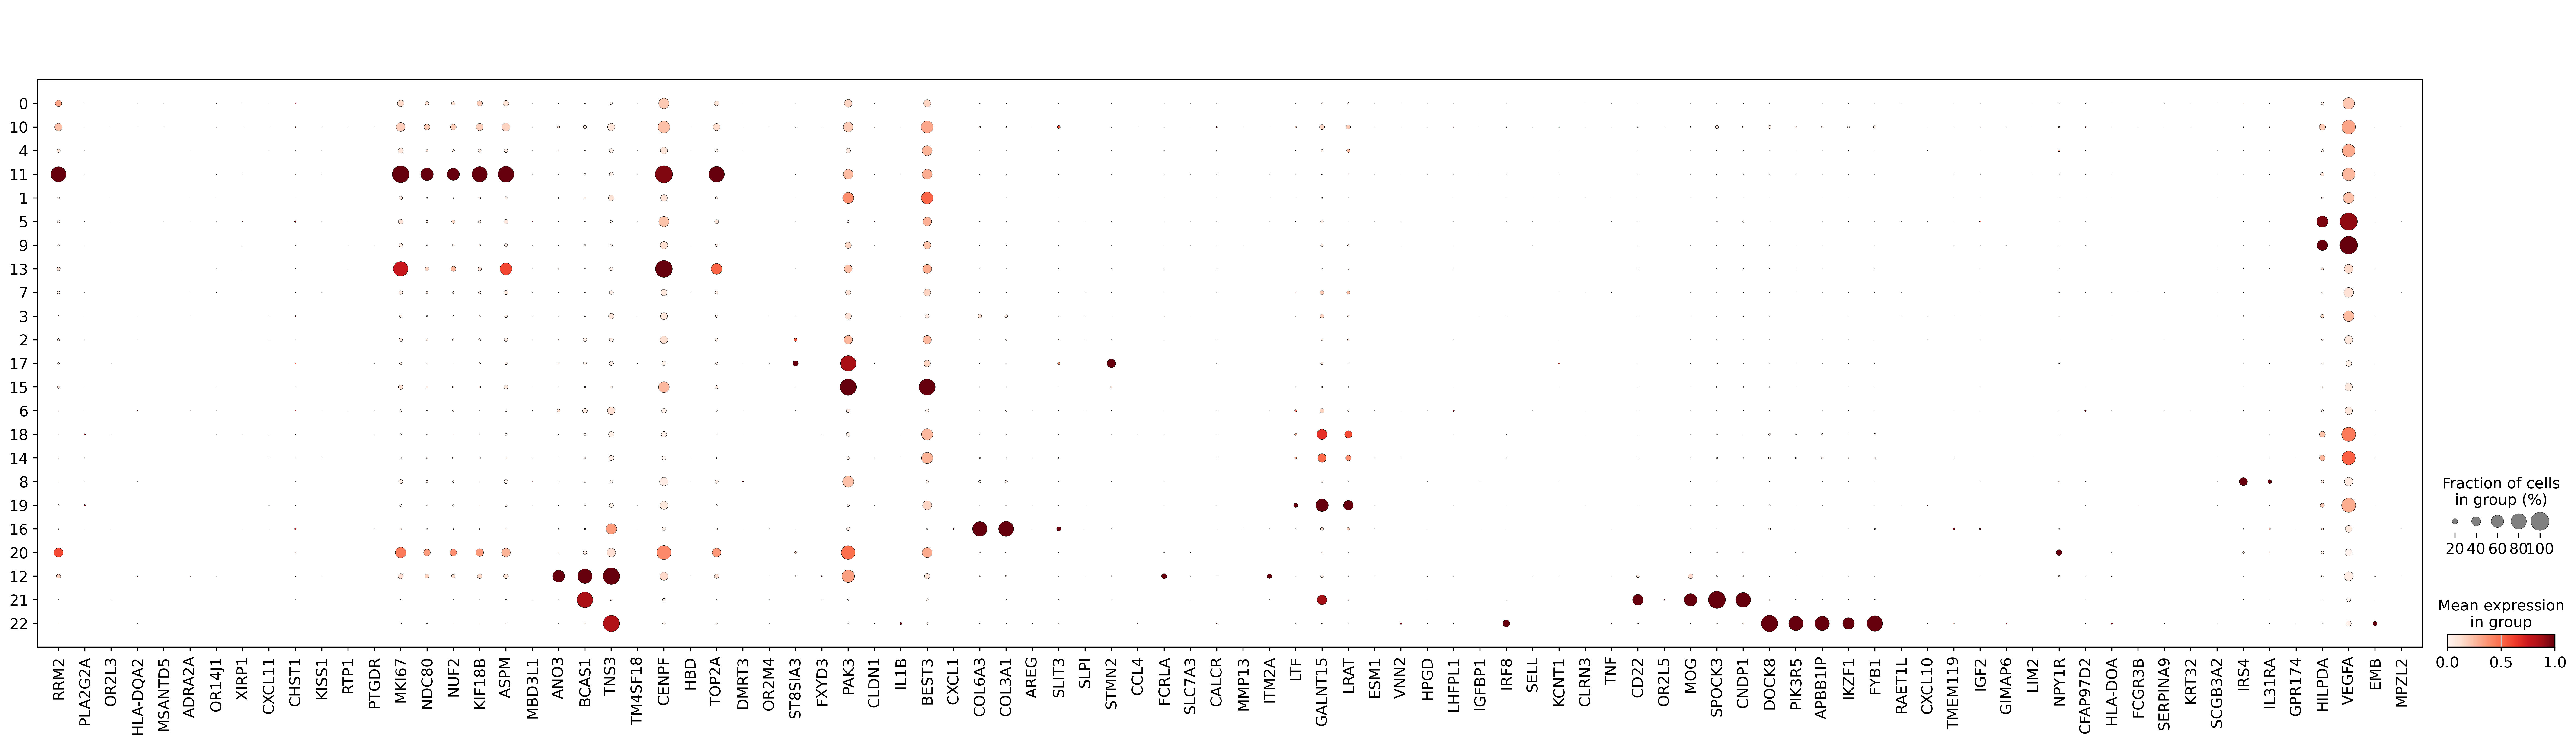

In [18]:
adata_log = adata.copy()
sc.pp.normalize_total(adata_log)
sc.pp.log1p(adata_log)

g = sc.pl.dotplot(
    adata_log, 
    marker_genes,
    dendrogram = False, 
    show = False,
    groupby = "leiden", 
    standard_scale = "var", 
)

t=g['mainplot_ax'].get_xticklabels() 
tx=list()
for x in t: tx.append(x.get_text())
ticklabels = [adata_log.var.loc[x]['gene_name'] for x in tx] 

_ = g['mainplot_ax'].set_xticklabels(ticklabels)

In [19]:
adata.write("/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_1_scvi/sce_all_post.h5ad")

In [20]:
norm_matrix = scvi_model.get_normalized_expression(
    adata = adata,
    library_size = 1
)
norm_matrix

ENSG00000000938  ENSG00000000971  ENSG00000001461  \
03_01_07__s1     2.625693e-06     1.321970e-06         0.000014   
03_01_09__s1     1.412781e-06     7.251736e-07         0.000018   
03_01_22__s1     4.418370e-06     2.676803e-06         0.000014   
03_01_25__s1     5.168039e-07     2.103021e-07         0.000034   
03_01_28__s1     1.863295e-06     5.438208e-07         0.000014   
...                       ...              ...              ...   
10_92_82__s2     3.248670e-05     1.065097e-04         0.000127   
10_93_87__s2     5.163016e-05     9.458070e-05         0.000110   
10_95_03__s2     2.267112e-05     1.341861e-04         0.000099   
10_95_60__s2     4.721999e-05     1.613119e-04         0.000109   
10_95_82__s2     8.304803e-05     9.697147e-05         0.000112   

              ENSG00000001626  ENSG00000001630  ENSG00000002587  \
03_01_07__s1         0.000012         0.000363         0.000162   
03_01_09__s1         0.000003         0.000325         0.000081   
03_01_22__s1         0.000007         0.000511         0.000073   
03_01_25__s1         0.000003         0.000260         0.000104   
03_01_28__s1         0.000008         0.000324         0.000133   
...                       ...              ...              ...   
10_92_82__s2         0.000874         0.000079         0.000041   
10_93_87__s2         0.001058         0.000033         0.000024   
10_95_03__s2         0.000740         0.000068         0.000042   
10_95_60__s2         0.000991         0.000065         0.000042   
10_95_82__s2         0.001119         0.000053         0.000034   

              ENSG00000002745  ENSG00000002746  ENSG00000003147  \
03_01_07__s1     1.229906e-06         0.000565         0.000301   
03_01_09__s1     2.583745e-06         0.000688         0.000272   
03_01_22__s1     1.811747e-05         0.000706         0.000244   
03_01_25__s1     1.721360e-07         0.000171         0.000250   
03_01_28__s1     6.207289e-06         0.000674         0.000209   
...                       ...              ...              ...   
10_92_82__s2     2.616411e-05         0.000735         0.000331   
10_93_87__s2     1.807563e-05         0.001530         0.000252   
10_95_03__s2     7.438185e-05         0.000486         0.000280   
10_95_60__s2     5.987793e-05         0.000844         0.000199   
10_95_82__s2     2.626500e-05         0.000651         0.000299   

              ENSG00000003400  ...  ENSG00000284762  ENSG00000284797  \
03_01_07__s1     9.259578e-07  ...         0.000216     1.792122e-06   
03_01_09__s1     1.727750e-06  ...         0.000245     2.204702e-06   
03_01_22__s1     2.421304e-06  ...         0.000336     1.719085e-06   
03_01_25__s1     4.836268e-07  ...         0.000233     2.467791e-07   
03_01_28__s1     1.150451e-06  ...         0.000344     2.004267e-06   
...                       ...  ...              ...              ...   
10_92_82__s2     4.749768e-05  ...         0.000245     2.680179e-05   
10_93_87__s2     5.238181e-05  ...         0.000136     1.055965e-05   
10_95_03__s2     4.938248e-05  ...         0.000212     2.234754e-05   
10_95_60__s2     9.595210e-05  ...         0.000197     3.720164e-05   
10_95_82__s2     3.331363e-05  ...         0.000175     1.953029e-05   

              ENSG00000284862  ENSG00000285891  ENSG00000286522  \
03_01_07__s1         0.000007     4.007843e-07     2.055822e-05   
03_01_09__s1         0.000018     1.245365e-07     2.606479e-06   
03_01_22__s1         0.000035     5.184036e-07     1.001685e-05   
03_01_25__s1         0.000008     1.035160e-07     3.122335e-05   
03_01_28__s1         0.000015     6.826257e-08     6.604781e-06   
...                       ...              ...              ...   
10_92_82__s2         0.000083     3.385175e-05     1.399773e-06   
10_93_87__s2         0.000033     2.379967e-05     8.781256e-08   
10_95_03__s2         0.000068     1.602205e-05     9.916106e-07   
10_95_60__s2         0.000099     1.741888e-05     1.153323e-06 

In [21]:
norm_matrix.transpose().to_csv(path_or_buf="/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_1_scvi/sce_all_norm.csv")

In [83]:
norm_cells = pd.read_csv("/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/3_1_norm_labels/norm_labels.csv")
# norm_cells.reset_index
# norm_cells.set_index("bc_wells")
norm_cells

bc_wells   class
0      03_01_07__s1  tumour
1      03_01_09__s1  tumour
2      03_01_22__s1  tumour
3      03_01_25__s1  tumour
4      03_01_28__s1  tumour
...             ...     ...
18038  10_92_82__s2  tumour
18039  10_93_87__s2  tumour
18040  10_95_03__s2  tumour
18041  10_95_60__s2  tumour
18042  10_95_82__s2  tumour

[18043 rows x 2 columns]

In [72]:
adata_tumour = adata_full
adata_tumour.obs.reset_index(drop = True, inplace = True)
adata_tumour.obs

bc_wells      sample species  gene_count  tscp_count  mread_count  \
0      03_01_07__s1  GL0028_PDN    hg38      2497.0      4775.0       7505.0   
1      03_01_09__s1  GL0028_PDN    hg38      4501.0     13503.0      21724.0   
2      03_01_22__s1  GL0028_PDN    hg38      2794.0      5074.0       8093.0   
3      03_01_25__s1  GL0028_PDN    hg38      2899.0      6638.0      10742.0   
4      03_01_28__s1  GL0028_PDN    hg38      2258.0      4825.0       7619.0   
...             ...         ...     ...         ...         ...          ...   
18038  10_92_82__s2    GL0128_T    hg38       716.0       759.0       1219.0   
18039  10_93_87__s2    GL0128_T    hg38      1085.0      1184.0       1900.0   
18040  10_95_03__s2    GL0128_T    hg38       667.0       711.0       1145.0   
18041  10_95_60__s2    GL0128_T    hg38       616.0       651.0       1039.0   
18042  10_95_82__s2    GL0128_T    hg38      2176.0      2560.0       4117.0   

       bc1_wind  bc2_wind  bc3_wind bc1_well  ... low_n_features  \
0           3.0       1.0       7.0       A3  ...          False   
1           3.0       1.0       9.0       A3  ...          False   
2           3.0       1.0      22.0       A3  ...          False   
3           3.0       1.0      25.0       A3  ...          False   
4           3.0       1.0      28.0       A3  ...          False   
...         ...       ...       ...      ...  ...            ...   
18038      10.0      92.0      82.0      A10  ...          False   
18039      10.0      93.0      87.0      A10  ...          False   
18040      10.0      95.0       3.0      A10  ...          False   
18041      10.0      95.0      60.0      A10  ...          False   
18042      10.0      95.0      82.0      A10  ...          False   

      high_subsets_mito_percent  discard  discard_mito  discard_feature  \
0                         False    False         False            False   
1                          True     True         False            False   
2                          True     True         False            False   
3                          True     True         False            False   
4                         False    False         False            False   
...                         ...      ...           ...              ...   
18038                      True     True         False            False   
18039                     False    False         False            False   
18040                      True     True         False            False   
18041                     False    False         False            False   
18042                     False    False         False            False   

       discard_final  sizeFactor  leiden_individual  leiden   class  
0              False    0.771396                  1       0  tumour  
1              False    2.158509                  1       1  tumour  
2              False    0.794660                  1       2  tumour  
3              False    1.048819                  2       3  tumour  
4              False    0.778393                  3       2  tumour  
...              ...         ...                ...     ...     ...  
18038          False    0.583790                  1       4  tumour  
18039          False    0.935829                  1       4  tumour  
18040          False    0.525300                  1       4  tumour  
18041          False    0.499918                  1       4  tumour  
18042          False    2.042713                  1       4  tumour  

[18043 rows x 31 columns]

In [73]:
adata_tumour.obs.merge(right = norm_cells, on = "bc_wells", how = "left")

bc_wells      sample species  gene_count  tscp_count  mread_count  \
0      03_01_07__s1  GL0028_PDN    hg38      2497.0      4775.0       7505.0   
1      03_01_09__s1  GL0028_PDN    hg38      4501.0     13503.0      21724.0   
2      03_01_22__s1  GL0028_PDN    hg38      2794.0      5074.0       8093.0   
3      03_01_25__s1  GL0028_PDN    hg38      2899.0      6638.0      10742.0   
4      03_01_28__s1  GL0028_PDN    hg38      2258.0      4825.0       7619.0   
...             ...         ...     ...         ...         ...          ...   
18038  10_92_82__s2    GL0128_T    hg38       716.0       759.0       1219.0   
18039  10_93_87__s2    GL0128_T    hg38      1085.0      1184.0       1900.0   
18040  10_95_03__s2    GL0128_T    hg38       667.0       711.0       1145.0   
18041  10_95_60__s2    GL0128_T    hg38       616.0       651.0       1039.0   
18042  10_95_82__s2    GL0128_T    hg38      2176.0      2560.0       4117.0   

       bc1_wind  bc2_wind  bc3_wind bc1_well  ... low_n_features  \
0           3.0       1.0       7.0       A3  ...          False   
1           3.0       1.0       9.0       A3  ...          False   
2           3.0       1.0      22.0       A3  ...          False   
3           3.0       1.0      25.0       A3  ...          False   
4           3.0       1.0      28.0       A3  ...          False   
...         ...       ...       ...      ...  ...            ...   
18038      10.0      92.0      82.0      A10  ...          False   
18039      10.0      93.0      87.0      A10  ...          False   
18040      10.0      95.0       3.0      A10  ...          False   
18041      10.0      95.0      60.0      A10  ...          False   
18042      10.0      95.0      82.0      A10  ...          False   

      high_subsets_mito_percent  discard  discard_mito  discard_feature  \
0                         False    False         False            False   
1                          True     True         False            False   
2                          True     True         False            False   
3                          True     True         False            False   
4                         False    False         False            False   
...                         ...      ...           ...              ...   
18038                      True     True         False            False   
18039                     False    False         False            False   
18040                      True     True         False            False   
18041                     False    False         False            False   
18042                     False    False         False            False   

       discard_final  sizeFactor  leiden_individual  leiden   class  
0              False    0.771396                  1       0  tumour  
1              False    2.158509                  1       1  tumour  
2              False    0.794660                  1       2  tumour  
3              False    1.048819                  2       3  tumour  
4              False    0.778393                  3       2  tumour  
...              ...         ...                ...     ...     ...  
18038          False    0.583790                  1       4  tumour  
18039          False    0.935829                  1       4  tumour  
18040          False    0.525300                  1       4  tumour  
18041          False    0.499918                  1       4  tumour  
18042          False    2.042713                  1       4  tumour  

[18043 rows x 31 columns]

In [74]:
adata_tumour.obs.set_index("bc_wells")

sample species  gene_count  tscp_count  mread_count  \
bc_wells                                                                
03_01_07__s1  GL0028_PDN    hg38      2497.0      4775.0       7505.0   
03_01_09__s1  GL0028_PDN    hg38      4501.0     13503.0      21724.0   
03_01_22__s1  GL0028_PDN    hg38      2794.0      5074.0       8093.0   
03_01_25__s1  GL0028_PDN    hg38      2899.0      6638.0      10742.0   
03_01_28__s1  GL0028_PDN    hg38      2258.0      4825.0       7619.0   
...                  ...     ...         ...         ...          ...   
10_92_82__s2    GL0128_T    hg38       716.0       759.0       1219.0   
10_93_87__s2    GL0128_T    hg38      1085.0      1184.0       1900.0   
10_95_03__s2    GL0128_T    hg38       667.0       711.0       1145.0   
10_95_60__s2    GL0128_T    hg38       616.0       651.0       1039.0   
10_95_82__s2    GL0128_T    hg38      2176.0      2560.0       4117.0   

              bc1_wind  bc2_wind  bc3_wind bc1_well bc2_well  ...  \
bc_wells                                                      ...   
03_01_07__s1       3.0       1.0       7.0       A3       A1  ...   
03_01_09__s1       3.0       1.0       9.0       A3       A1  ...   
03_01_22__s1       3.0       1.0      22.0       A3       A1  ...   
03_01_25__s1       3.0       1.0      25.0       A3       A1  ...   
03_01_28__s1       3.0       1.0      28.0       A3       A1  ...   
...                ...       ...       ...      ...      ...  ...   
10_92_82__s2      10.0      92.0      82.0      A10       H8  ...   
10_93_87__s2      10.0      93.0      87.0      A10       H9  ...   
10_95_03__s2      10.0      95.0       3.0      A10      H11  ...   
10_95_60__s2      10.0      95.0      60.0      A10      H11  ...   
10_95_82__s2      10.0      95.0      82.0      A10      H11  ...   

             low_n_features  high_subsets_mito_percent  discard  discard_mito  \
bc_wells                                                                        
03_01_07__s1          False                      False    False         False   
03_01_09__s1          False                       True     True         False   
03_01_22__s1          False                       True     True         False   
03_01_25__s1          False                       True     True         False   
03_01_28__s1          False                      False    False         False   
...                     ...                        ...      ...           ...   
10_92_82__s2          False                       True     True         False   
10_93_87__s2          False                      False    False         False   
10_95_03__s2          False                       True     True         False   
10_95_60__s2          False                      False    False         False   
10_95_82__s2          False                      False    False         False   

              discard_feature  discard_final  sizeFactor  leiden_individual  \
bc_wells                                                                      
03_01_07__s1            False          False    0.771396                  1   
03_01_09__s1            False          False    2.158509                  1   
03_01_22__s1            False          False    0.794660                  1   
03_01_25__s1            False          False    1.048819                  2   
03_01_28__s1            False          False    0.778393                  3   
...                       ...            ...         ...                ...   
10_92_82__s2            False          False    0.583790                  1   
10_93_87__s2            False          False    0.935829                  1   
10_95_03__s2            False          False    0.525300                  1   
10_95_60__s2            False          False    0.499918                  1   
10_95_82__s2            False          False    2.042713                  1   

              leiden   class  
bc_wells                      
03_01_07__s1       0  tumo

In [82]:
(adata_tumour.obs["class"] == "tumour") & (adata) (~adata_tumour.obs["sample"].isin(["GL0128_PDN", "GL0128_PDO", "GL0128_T"]))

SyntaxError: invalid syntax (109011925.py, line 1)

In [67]:
a = adata_full

In [68]:
a.obs

bc_wells      sample species  gene_count  tscp_count  \
03_01_07__s1  03_01_07__s1  GL0028_PDN    hg38      2497.0      4775.0   
03_01_09__s1  03_01_09__s1  GL0028_PDN    hg38      4501.0     13503.0   
03_01_22__s1  03_01_22__s1  GL0028_PDN    hg38      2794.0      5074.0   
03_01_25__s1  03_01_25__s1  GL0028_PDN    hg38      2899.0      6638.0   
03_01_28__s1  03_01_28__s1  GL0028_PDN    hg38      2258.0      4825.0   
...                    ...         ...     ...         ...         ...   
10_92_82__s2  10_92_82__s2    GL0128_T    hg38       716.0       759.0   
10_93_87__s2  10_93_87__s2    GL0128_T    hg38      1085.0      1184.0   
10_95_03__s2  10_95_03__s2    GL0128_T    hg38       667.0       711.0   
10_95_60__s2  10_95_60__s2    GL0128_T    hg38       616.0       651.0   
10_95_82__s2  10_95_82__s2    GL0128_T    hg38      2176.0      2560.0   

              mread_count  bc1_wind  bc2_wind  bc3_wind bc1_well  ...  \
03_01_07__s1       7505.0       3.0       1.0       7.0       A3  ...   
03_01_09__s1      21724.0       3.0       1.0       9.0       A3  ...   
03_01_22__s1       8093.0       3.0       1.0      22.0       A3  ...   
03_01_25__s1      10742.0       3.0       1.0      25.0       A3  ...   
03_01_28__s1       7619.0       3.0       1.0      28.0       A3  ...   
...                   ...       ...       ...       ...      ...  ...   
10_92_82__s2       1219.0      10.0      92.0      82.0      A10  ...   
10_93_87__s2       1900.0      10.0      93.0      87.0      A10  ...   
10_95_03__s2       1145.0      10.0      95.0       3.0      A10  ...   
10_95_60__s2       1039.0      10.0      95.0      60.0      A10  ...   
10_95_82__s2       4117.0      10.0      95.0      82.0      A10  ...   

             low_lib_size low_n_features  high_subsets_mito_percent  discard  \
03_01_07__s1        False          False                      False    False   
03_01_09__s1        False          False                       True     True   
03_01_22__s1        False          False                       True     True   
03_01_25__s1        False          False                       True     True   
03_01_28__s1        False          False                      False    False   
...                   ...            ...                        ...      ...   
10_92_82__s2        False          False                       True     True   
10_93_87__s2        False          False                      False    False   
10_95_03__s2        False          False                       True     True   
10_95_60__s2        False          False                      False    False   
10_95_82__s2        False          False                      False    False   

              discard_mito  discard_feature  discard_final  sizeFactor  \
03_01_07__s1         False            False          False    0.771396   
03_01_09__s1         False            False          False    2.158509   
03_01_22__s1         False            False          False    0.794660   
03_01_25__s1         False            False          False    1.048819   
03_01_28__s1         False            False          False    0.778393   
...                    ...              ...            ...         ...   
10_92_82__s2         False            False          False    0.583790   
10_93_87__s2         False            False          False    0.935829   
10_95_03__s2         False            False          False    0.525300   
10_95_60__s2         False            False          False    0.499918   
10_95_82__s2         False            False          False    2.042713   

              leiden_individual  leiden  
03_01_07__s1                  1       0  
03_01_09__s1                  1       1  
03_01_22__s1                  1       2  
03_01_25__s1                  2       3  
03_01_28__s1                  3       2  
...                         ...     ...  
10_92_82__s2                  1       4  
10_93_87__s2                  1       4  
10_95_03__s2            